In [97]:
# Classical data science toolbox
import pandas as pd
import numpy as np
# Module specific packages
from scripts import data
# Plotting packages
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
# For missing value analysis
import missingno as mno
# Datetime handling
import datetime as dt

In [87]:
# Get data dictionary
data_dict = data.get_data_dict()
# And store in separate data-frames
purchases = data_dict['purchases']
users = data_dict['users']

# Fix dates
purchases['purchased_at'] = pd.to_datetime(purchases.purchased_at)
users['created_at'] = pd.to_datetime(users.created_at)

### Purchase analysis
In the case of purchases, we focus on:
- Possible outliers,
- Dates beyond current year and month
- Which products have been sold the most, and
- Correlation between the time when the item was bought, and the correlation between buying product1 and product2.

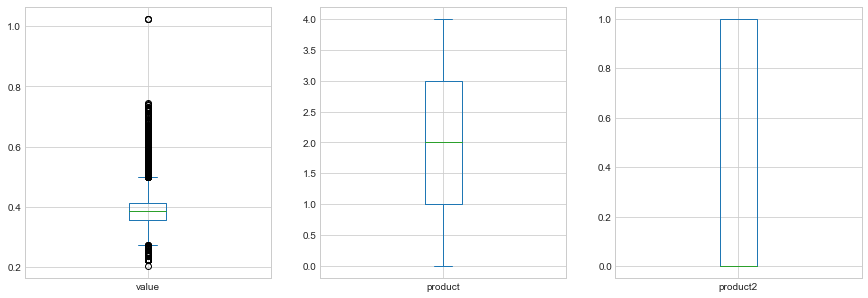

In [88]:
# Look for possible outliers
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
for n, col in enumerate(purchases.drop(['user_id', 'purchased_at'], axis = 1).columns) :
    purchases[col].plot.box(
        ax = axes[n]
    )
plt.show()

No outliers have been found.

In [89]:
purchases.purchased_at.max(), purchases.purchased_at.min()

(Timestamp('2021-08-11 18:20:29'), Timestamp('2017-08-12 19:02:07'))

As it can be seen above, purchased_at moves within a reasonable range.

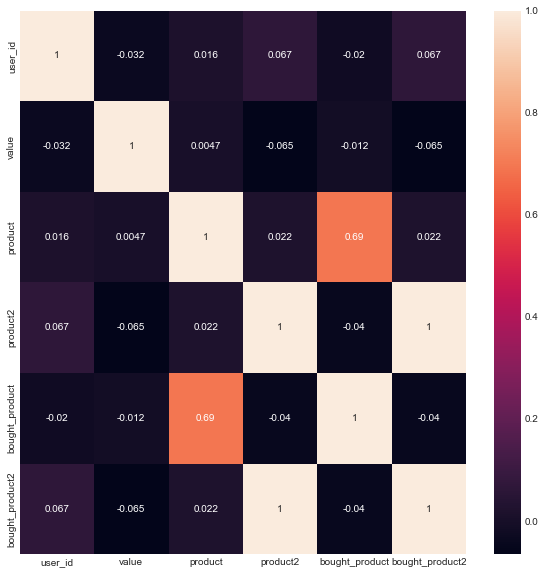

In [90]:
# Make columns if bought
purchases['bought_product'] = purchases['product'].astype(bool).astype(int)
purchases['bought_product2'] = purchases['product2'].astype(bool).astype(int)
# Plot correlations
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(
    purchases.corr('pearson'),
    annot = True,
    ax = ax
)
plt.show()

The pearson correlation coefficients are too low to reach any conclusions.

### Users analysis
Here, we can
- Fix birthyears/created_at that are either prior to 1930, and beyound current year and month.
    - In the first case, simply replace by "NaN".
    - In the second one, drop.
- Nunique values in each column
- Analyze missing values -- correlation and quantities.

In [91]:
# Print min and max of created_at column
print(users.created_at.min(), users.created_at.max())
# Replace weird values by NaN
users.loc[
    (users.created_at.dt.date >= dt.date.today()) | (users.created_at.dt.date < dt.date(year = 1930, month = 1, day = 1)),
    'created_at'
] = np.nan

2016-08-12 19:22:29 2031-07-05 11:57:35


It is impossible that an account was created after the current day and month, so those are replaced by NaN values. Similarly for the birthyear, the missing values are filled as follows:

In [95]:
users.loc[
    # A user should have less than 100 years...and more than 16
    (users.birthyear <= 1915) | (users.birthyear >= 2006),
    'birthyear'
] = np.nan

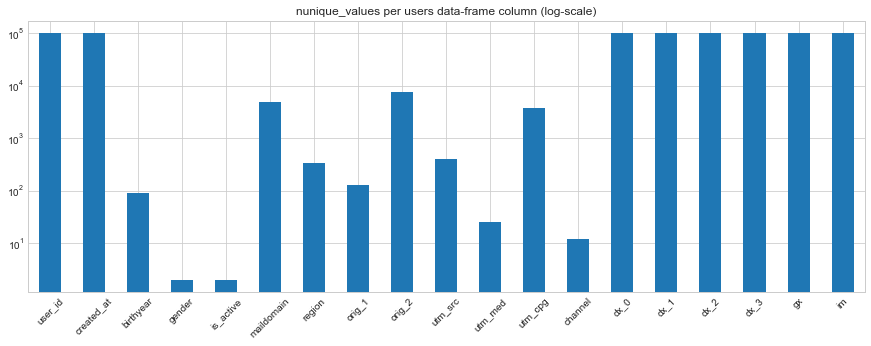

In [135]:
users.nunique().plot.bar(
    logy = True,
    figsize = (15, 5),
    rot = 45,
    title = 'nunique_values per users data-frame column (log-scale)'
)
plt.show()

Finally, analyze missing values

<AxesSubplot:>

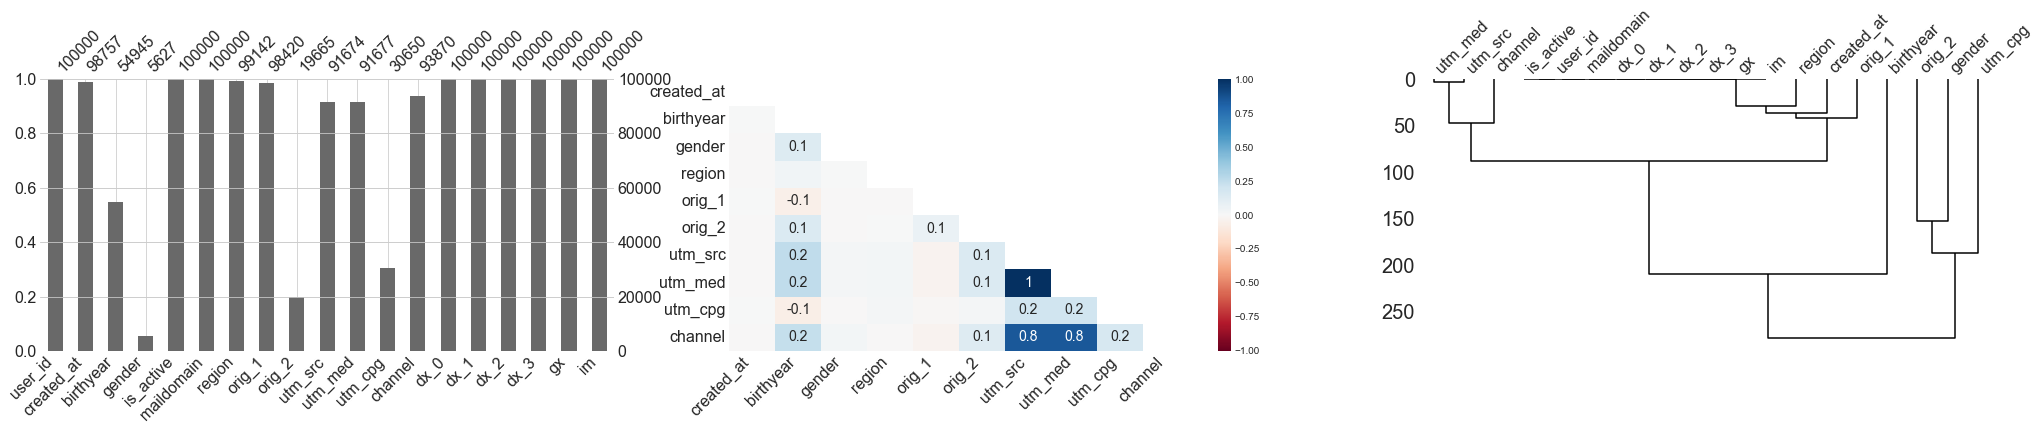

In [136]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (35, 5))
mno.bar(users, ax = axes[0])
mno.heatmap(users, ax = axes[1])
mno.dendrogram(users, ax = axes[2])

From here it is observed that:
1. The gender is almost never revealed.
2. Origin_2 is also missing in most occasions.
3. utm_cpg is missing in most cases.
4. utm_src and utm_med are missing in the exact same cases.

### Target data-frame analysis and munging
Our goal is to predict the value of the purchases each `user_id` will perform at a given date. For that reason, we start by fixing the data-frame so that it is given in
the format $t|i_1|\cdots|i_N$, where $t$ is the time (with a daily granularity), $i_k$ contains the amount the $k$-th user_id spent, and $N$ is the total number of user_id.
**Note**: For computation purposes, we illustrate the process using only 10 user_ids first.

In [176]:
merged_df = pd.merge(
    purchases,
    users
)[['user_id', 'purchased_at', 'value', 'orig_1']]
merged_df['user_id'] = merged_df.user_id.fillna(-1).astype(int).astype(str)
merged_df['orig_1'] = merged_df.orig_1.fillna(-1).astype(int).astype(str)
merged_df['t'] = merged_df.purchased_at.dt.date

hierarchy = {
    'total' : merged_df.orig_1.unique().tolist()
}
for orig_1 in merged_df.orig_1.unique() :
    hierarchy[orig_1] = merged_df[merged_df.orig_1 == orig_1].user_id.unique().tolist()
    hierarchy[orig_1] = [orig_1 + '_' + user_id for user_id in hierarchy[orig_1]]

from hts import HTSRegressor
Y_bottom = merged_df.groupby(
    ['t', 'orig_1', 'user_id']
).value.sum().reset_index().pivot(
    index = 't',
    columns = ['orig_1', 'user_id'],
    values = 'value'
)
Y_bottom = Y_bottom.reindex(
    pd.date_range(
        start = Y_bottom.index.min(),
        end = Y_bottom.index.max(),
        freq = '1d'
    )
).fillna(0)
Y_bottom.columns = ["_".join(cols) for cols in Y_bottom.columns]

In [177]:
Y_mid = merged_df.groupby(
    ['t', 'orig_1']
).value.sum().reset_index().pivot(
    index = 't',
    columns = ['orig_1'],
    values = 'value'
).reindex(
    pd.date_range(
        start = Y_bottom.index.min(),
        end = Y_bottom.index.max(),
        freq = '1d'
    )
).fillna(0)
Y_total = Y_mid.sum(axis = 1).rename('total')
Y = pd.concat(
    (Y_bottom, Y_mid, Y_total), axis = 1
)
Y

,30_1690,30_2020,30_2022,30_2023,75_181,78_945,30_1577,30_2031,78_1850,30_1760,...,87,88,89,93,94,95,96,97,99,total
2017-08-12,0.472902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472902
2017-08-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-08-14,0.000000,1.212912,0.651416,0.951341,0.948683,0.437971,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.202323
2017-08-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-08-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.476731,0.476837,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.953569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.802193
2021-08-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.271813
2021-08-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.594107
2021-08-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.233659


In [178]:
from hts.hierarchy import HierarchyTree
tree = HierarchyTree.from_nodes(
    nodes = hierarchy,
    df = Y
)
print(tree)

- total
   |- 78
   |  |- 78_1
   |  |- 78_104
   |  |- 78_115
   |  |- 78_117
   |  |- 78_168
   |  |- 78_358
   |  |- 78_394
   |  |- 78_450
   |  |- 78_514
   |  |- 78_658
   |  |- 78_773
   |  |- 78_869
   |  |- 78_883
   |  |- 78_934
   |  |- 78_945
   |  |- 78_975
   |  |- 78_983
   |  |- 78_1014
   |  |- 78_1035
   |  |- 78_1050
   |  |- 78_1076
   |  |- 78_1100
   |  |- 78_1109
   |  |- 78_1146
   |  |- 78_1203
   |  |- 78_1303
   |  |- 78_1403
   |  |- 78_1430
   |  |- 78_1490
   |  |- 78_1612
   |  |- 78_1619
   |  |- 78_1729
   |  |- 78_1771
   |  |- 78_1815
   |  |- 78_1844
   |  |- 78_1850
   |  |- 78_1909
   |  |- 78_2071
   |  |- 78_2079
   |  |- 78_2087
   |  |- 78_2123
   |  |- 78_2198
   |  |- 78_2307
   |  |- 78_2334
   |  |- 78_2335
   |  |- 78_2361
   |  |- 78_2441
   |  |- 78_2520
   |  |- 78_2555
   |  |- 78_2589
   |  |- 78_2603
   |  |- 78_2791
   |  |- 78_2792
   |  |- 78_2818
   |  |- 78_2915
   |  |- 78_2933
   |  |- 78_2959
   |  |- 78_2971
   |  |- 78_2990

In [ ]:
from hts import HTSRegressor

clf = HTSRegressor(model='arima', revision_method='OLS', n_jobs=-1)
model = clf.fit(Y, hierarchy)